# Lab 2 - Tagging

## 1 – Ambiguity
Use the Brown Corpus and

In [53]:
import nltk
from nltk.corpus import brown

**(a) Print the 5 most frequent tags in the corpus**

In [54]:
#computing the frequency distribution of the tagged words, filtered by alphanumeric characters
brown_tagged = brown.tagged_words(tagset='universal')
brown_tagged = [(word.lower(), tag) for (word,tag) in brown_tagged if word.isalnum()]

brown_fdist = nltk.FreqDist(brown_tagged)
five_most_common = brown_fdist.most_common(5)

print("The five most common tagged words are:")
for word in five_most_common:
    print(word)

The five most common tagged words are:
(('the', 'DET'), 69968)
(('of', 'ADP'), 36410)
(('and', 'CONJ'), 28850)
(('a', 'DET'), 23070)
(('in', 'ADP'), 20866)


**(b) How many words are ambiguous, in the sense that they appear with more than two tags?**

In [55]:
brown_cond_freq = nltk.ConditionalFreqDist(brown_tagged)
ambiguous_words = []

for word in brown_cond_freq.conditions():
   if(len(brown_cond_freq[word]) > 2):
      ambiguous_words.append(word)

print(len(ambiguous_words),' words are ambiguous')

272  words are ambiguous


**(c) Print the percentage of ambiguous words in the corpus1**

In [56]:
print(len(ambiguous_words), len(brown_tagged))
print("{:.4f}".format(len(ambiguous_words)*100/len(brown_tagged)), "% of the words in Brown corpus are ambiguous")

272 988331
0.0275 % of the words in Brown corpus are ambiguous


**(d) Find the top 5 words (longer than 4 characters) with the highest number of distinct tags. Select one
of them and print out a sentence with the word in its different forms.**

In [57]:
words_longer_4_char = {}
for word in brown_cond_freq.conditions():
   if(len(word) > 4):
      tags = brown_cond_freq[word].keys()
      words_longer_4_char[word] = list(tags)

print("The top 5 words with the highest number of tags are:")
for word in sorted(words_longer_4_char, key=lambda word: len(words_longer_4_char[word]), reverse = True)[:5]:
    print(word, words_longer_4_char[word])

The top 5 words with the highest number of tags are:
round ['NOUN', 'VERB', 'ADJ', 'ADV', 'ADP']
present ['ADJ', 'ADV', 'NOUN', 'VERB']
about ['ADP', 'ADV', 'PRT', 'X']
still ['ADV', 'VERB', 'ADJ', 'NOUN']
close ['NOUN', 'ADJ', 'ADV', 'VERB']


In [58]:
# finding sentences for all POS for "present"
present_POS = ['ADJ', 'ADV', 'NOUN', 'VERB']

for sentence in brown.tagged_sents(tagset='universal'):
    for (word, tag) in sentence:
        if(word == 'present' and tag in present_POS):
            print("'Present' as " + tag)
            print(sentence, '\n')
            present_POS.remove(tag)

'Present' as ADJ
[('The', 'DET'), ("mayor's", 'NOUN'), ('present', 'ADJ'), ('term', 'NOUN'), ('of', 'ADP'), ('office', 'NOUN'), ('expires', 'VERB'), ('Jan.', 'NOUN'), ('1', 'NUM'), ('.', '.')] 

'Present' as ADV
[('In', 'ADP'), ('1960', 'NUM'), ('more', 'ADJ'), ('than', 'ADP'), ('6,000', 'NUM'), ('Communist', 'NOUN'), ('technicians', 'NOUN'), ('were', 'VERB'), ('present', 'ADV'), ('in', 'ADP'), ('those', 'DET'), ('countries', 'NOUN'), ('.', '.')] 

'Present' as NOUN
[('But', 'CONJ'), ('an', 'DET'), ('official', 'ADJ'), ('statement', 'NOUN'), ('adopted', 'VERB'), ('by', 'ADP'), ('the', 'DET'), ('33-man', 'ADJ'), ('Emory', 'NOUN'), ('board', 'NOUN'), ('at', 'ADP'), ('its', 'DET'), ('annual', 'ADJ'), ('meeting', 'NOUN'), ('Friday', 'NOUN'), ('noted', 'VERB'), ('that', 'ADP'), ('state', 'NOUN'), ('taxing', 'VERB'), ('requirements', 'NOUN'), ('at', 'ADP'), ('present', 'NOUN'), ('are', 'VERB'), ('a', 'DET'), ('roadblock', 'NOUN'), ('to', 'ADP'), ('accepting', 'VERB'), ('Negroes', 'NOUN'), ('

**(e) Discuss and think about how you would attack the problem of resolving ambiguous words for a
predictive smartphone keyboard**

I would attack the problem by basing the predictivity algorithm on bigrams. In this way the POS of the last written word has an impact on the probability of the word being predicted.

## 2 – Training a tagger

Explore the performance of a tagger using the Brown Corpus and NPS Chat Corpus as data sources, with different ratios of train/test data. Use the following ratios:

• Brown 90%/NPS 10%
• Brown 50%/NPS 50%
• NPS 90%/Brown 10%
• NPS 50%/Brown 50%

Create the taggers listed below and comment your results.

**(a) Create a DefaultTagger using the most common tag in each corpus as the default tag.**

In [59]:
from nltk.corpus import brown, nps_chat
from nltk import DefaultTagger
from nltk.probability import FreqDist
from sklearn.model_selection import train_test_split as split
from nltk.tag import DefaultTagger, UnigramTagger, BigramTagger

#nltk.download('nps_chat')

In [60]:
# from https://www.nltk.org/book/ch05.html

tags_brown = [tag for (word, tag) in brown.tagged_words()]
print('Browns most frequent tag is: ', nltk.FreqDist(tags_brown).max())

tags_nps = [tag for (word, tag) in nps_chat.tagged_words()]
print('NPS most frequent tag is: ',nltk.FreqDist(tags_nps).max())

default_tagger_brown = DefaultTagger('NN')
default_tagger_nps = DefaultTagger('UH')

Browns most frequent tag is:  NN
NPS most frequent tag is:  UH


**(b) Create a combined tagger with the RegEx tagger (see Ch. 5, sec. 4.2) with an initial backoff using
the most common default tag. Then, use n-gram taggers as backoff taggers (e.g., UnigramTagger, BigramTagger, TrigramTagger). The ordering is up to you, but justify your choice. Calculate the accuracy of each of the four train/test permutations.**

In [61]:
brown_tagged = nltk.corpus.brown.tagged_sents()
brown_train_50, brown_test_50 = split(brown_tagged, test_size=0.5)

nps_tagged = nltk.corpus.nps_chat.tagged_posts()
nps_train_50, nps_test_50 = split(nps_tagged, test_size=0.5)

In [62]:
# Creating a combined tagger with the RegEx tagger with an initial backoff using the most common default tag. 
patterns = [
    (r'.*ing$', 'VBG'),                # gerunds
    (r'.*ed$', 'VBD'),                 # simple past
    (r'.*es$', 'VBZ'),                 # 3rd singular present
    (r'.*ould$', 'MD'),                # modals
    (r'.*\'s$', 'NN$'),                # possessive nouns
    (r'.*s$', 'NNS'),                  # plural nouns
    (r'^-?[0-9]+(\.[0-9]+)?$', 'CD'),  # cardinal numbers
]
regexp_tagger_brown_backoff = nltk.RegexpTagger(patterns, backoff = default_tagger_brown)
regexp_tagger_nps_backoff = nltk.RegexpTagger(patterns, backoff = default_tagger_nps)

#Creating bigram taggers with unigram backoff taggers

combined_brown_unigram_tagger_regex_backoff = UnigramTagger(train = brown_train_50, backoff = regexp_tagger_brown_backoff)
combined_brown_bigram_tagger_unigram_backoff = BigramTagger(train = brown_train_50, backoff = combined_brown_unigram_tagger_regex_backoff)

combined_nps_unigram_tagger_regex_backoff = UnigramTagger(train = nps_train_50, backoff = regexp_tagger_nps_backoff)
combined_nps_bigram_tagger_unigram_backoff = BigramTagger(train = nps_train_50, backoff = combined_nps_unigram_tagger_regex_backoff)

In [63]:

# Calculate the accuracy of each of the four train/test permutations.
print('Accuracy of Brown train data on Brown test data', 
    '{:.3f}'.format(combined_brown_bigram_tagger_unigram_backoff.accuracy(brown_test_50)))

print('Accuracy of Brown train data on NPS test data', 
    '{:.3f}'.format(combined_brown_bigram_tagger_unigram_backoff.accuracy(nps_test_50)))
    
print('Accuracy of NPS train data on NPS test data', 
    '{:.3f}'.format(combined_nps_bigram_tagger_unigram_backoff.accuracy(nps_test_50)))
    
print('Accuracy of NPS train data on Brown test data', 
    '{:.3f}'.format(combined_nps_bigram_tagger_unigram_backoff.accuracy(brown_test_50)))


Accuracy of Brown train data on Brown test data 0.918
Accuracy of Brown train data on NPS test data 0.354
Accuracy of NPS train data on NPS test data 0.866
Accuracy of NPS train data on Brown test data 0.427


**(c) Select a dataset split of your choice and print a table containing the precision, recall and f-measure
for the top 5 most common tags (look up truncate in the documentation) and sort each score by
count. Do this for all your chosen variations of backoffs (e.g., DefaultTagger, UnigramTagger and
BigramTagger).**

In [64]:
print('Bigram with Unigram backoff, trained on Brown data \n', combined_brown_bigram_tagger_unigram_backoff.evaluate_per_tag(brown_train_50, truncate=5, sort_by_count=True))
print('Bigram with Unigram backoff, trained on NPS data \n', combined_nps_bigram_tagger_unigram_backoff.evaluate_per_tag(brown_train_50, truncate=5, sort_by_count=True))

Bigram with Unigram backoff, trained on Brown data 
 Tag | Prec.  | Recall | F-measure
----+--------+--------+-----------
 NN | 0.9787 | 0.9858 | 0.9822
 IN | 0.9373 | 0.9273 | 0.9323
 AT | 0.9928 | 0.9983 | 0.9955
 JJ | 0.9528 | 0.9737 | 0.9631
  . | 0.9978 | 0.9982 | 0.9980

Bigram with Unigram backoff, trained on NPS data 
 Tag | Prec.  | Recall | F-measure
----+--------+--------+-----------
 NN | 0.8305 | 0.2847 | 0.4240
 IN | 0.8276 | 0.8351 | 0.8313
 AT | 0.0000 | 0.0000 | 0.0000
 JJ | 0.5829 | 0.2639 | 0.3634
  . | 0.9889 | 0.8590 | 0.9194



In [65]:
print('Unigram with Regex backoff, trained on Brown data \n', combined_brown_unigram_tagger_regex_backoff.evaluate_per_tag(brown_train_50, truncate=5, sort_by_count=True))
print('Unigram with Regex backoff, trained on NPS data \n', combined_nps_unigram_tagger_regex_backoff.evaluate_per_tag(brown_train_50, truncate=5, sort_by_count=True))

Unigram with Regex backoff, trained on Brown data 
 Tag | Prec.  | Recall | F-measure
----+--------+--------+-----------
 NN | 0.9435 | 0.9522 | 0.9478
 IN | 0.9430 | 0.8873 | 0.9143
 AT | 0.9846 | 1.0000 | 0.9922
 JJ | 0.9215 | 0.9554 | 0.9382
  . | 0.9901 | 0.9993 | 0.9947

Unigram with Regex backoff, trained on NPS data 
 Tag | Prec.  | Recall | F-measure
----+--------+--------+-----------
 NN | 0.8254 | 0.2759 | 0.4136
 IN | 0.8266 | 0.8434 | 0.8349
 AT | 0.0000 | 0.0000 | 0.0000
 JJ | 0.5828 | 0.2676 | 0.3667
  . | 0.9891 | 0.9076 | 0.9466



In [66]:
print('Regex with most frquent word in Brown (NN) backoff, trained on NPS data \n', regexp_tagger_brown_backoff.evaluate_per_tag(brown_train_50, truncate=5, sort_by_count=True))
print('Regex with most frquent word in NPS (UH) backoff, trained on NPS data \n', regexp_tagger_nps_backoff.evaluate_per_tag(brown_train_50, truncate=5, sort_by_count=True))


Regex with most frquent word in Brown (NN) backoff, trained on NPS data 
 Tag | Prec.  | Recall | F-measure
----+--------+--------+-----------
 NN | 0.1501 | 0.9383 | 0.2588
 IN | 0.0000 | 0.0000 | 0.0000
 AT | 0.0000 | 0.0000 | 0.0000
 JJ | 0.0000 | 0.0000 | 0.0000
  . | 0.0000 | 0.0000 | 0.0000

Regex with most frquent word in NPS (UH) backoff, trained on NPS data 
 Tag | Prec.  | Recall | F-measure
----+--------+--------+-----------
 NN | 0.0000 | 0.0000 | 0.0000
 IN | 0.0000 | 0.0000 | 0.0000
 AT | 0.0000 | 0.0000 | 0.0000
 JJ | 0.0000 | 0.0000 | 0.0000
  . | 0.0000 | 0.0000 | 0.0000



**(d) Using the Brown Corpus, create a baseline tagger (e.g. Unigram) with a lookup model (see Ch. 5,
sec. 4.3). The model should handle the most 200 common words and store the tags. Evaluate the
accuracy on the above permutations of train/test data.**

In [67]:
fd = nltk.FreqDist(brown.words())
cfd = nltk.ConditionalFreqDist(brown.tagged_words())
most_freq_words = fd.most_common(200)
likely_tags = dict((word, cfd[word].max()) for (word, _) in most_freq_words)
baseline_tagger_most_frequent_words = nltk.UnigramTagger(model=likely_tags)

print('Evaluating Brown train data', '{:.4}'.format(baseline_tagger_most_frequent_words.accuracy(brown_train_50)))
print('Evaluating Brown test data', '{:.4}'.format(baseline_tagger_most_frequent_words.accuracy(brown_test_50)))
print('Evaluating NPS train data', '{:.4}'.format(baseline_tagger_most_frequent_words.accuracy(nps_train_50)))
print('Evaluating NPS test data', '{:.4}'.format(baseline_tagger_most_frequent_words.accuracy(nps_test_50)))

Evaluating Brown train data 0.5338
Evaluating Brown test data 0.5349
Evaluating NPS train data 0.1721
Evaluating NPS test data 0.1697


**(e) With an arbitrary text from another corpus (or an article you scraped in Lab 1), use the tagger you
just created and print a few tagged sentences.**

In [68]:
#with the help of this Q&A in Stackoverflow
#https://stackoverflow.com/questions/48768084/nltk-unigramtagger-typeerror-unhashable-type-list

from nltk.corpus import inaugural
#nltk.download('inaugural')

inaugural_text = inaugural.sents()[3:5]
inaugural_text = [tuple(sent) for sent in inaugural_text]

inaugural_tagged = [baseline_tagger_most_frequent_words.tag(word) for word in inaugural_text]
print(inaugural_tagged)

[[('On', None), ('the', 'AT'), ('other', 'AP'), ('hand', None), (',', ','), ('the', 'AT'), ('magnitude', None), ('and', 'CC'), ('difficulty', None), ('of', 'IN'), ('the', 'AT'), ('trust', None), ('to', 'TO'), ('which', 'WDT'), ('the', 'AT'), ('voice', None), ('of', 'IN'), ('my', 'PP$'), ('country', None), ('called', None), ('me', 'PPO'), (',', ','), ('being', 'BEG'), ('sufficient', None), ('to', 'TO'), ('awaken', None), ('in', 'IN'), ('the', 'AT'), ('wisest', None), ('and', 'CC'), ('most', 'QL'), ('experienced', None), ('of', 'IN'), ('her', 'PP$'), ('citizens', None), ('a', 'AT'), ('distrustful', None), ('scrutiny', None), ('into', 'IN'), ('his', 'PP$'), ('qualifications', None), (',', ','), ('could', 'MD'), ('not', '*'), ('but', 'CC'), ('overwhelm', None), ('with', 'IN'), ('despondence', None), ('one', 'CD'), ('who', 'WPS'), ('(', '('), ('inheriting', None), ('inferior', None), ('endowments', None), ('from', 'IN'), ('nature', None), ('and', 'CC'), ('unpracticed', None), ('in', 'IN'), 

**(f) Experiment with different ratios and using only one dataset with a train/test split. Explain your
findings.**

In [69]:
nps_tagged = nltk.corpus.nps_chat.tagged_posts()
nps_train_90, nps_test_10 = split(nps_tagged, test_size=0.1)
nps_train_80, nps_test_20 = split(nps_tagged, test_size=0.2)
nps_train_50, nps_test_50 = split(nps_tagged, test_size=0.5)
nps_train_20, nps_test_80 = split(nps_tagged, test_size=0.8)
nps_train_10, nps_test_90 = split(nps_tagged, test_size=0.9)

In [70]:
combined_nps90_unigram_tagger_regex_backoff = UnigramTagger(train = nps_train_90, backoff = regexp_tagger_nps_backoff)
combined_nps80_unigram_tagger_regex_backoff = UnigramTagger(train = nps_train_80, backoff = regexp_tagger_nps_backoff)
combined_nps50_unigram_tagger_regex_backoff = UnigramTagger(train = nps_train_50, backoff = regexp_tagger_nps_backoff)
combined_nps20_unigram_tagger_regex_backoff = UnigramTagger(train = nps_train_20, backoff = regexp_tagger_nps_backoff)
combined_nps10_unigram_tagger_regex_backoff = UnigramTagger(train = nps_train_10, backoff = regexp_tagger_nps_backoff)

In [71]:
nps_train90 = combined_nps90_unigram_tagger_regex_backoff.accuracy(nps_test_10)
nps_train80 = combined_nps80_unigram_tagger_regex_backoff.accuracy(nps_test_20)
nps_train50 = combined_nps50_unigram_tagger_regex_backoff.accuracy(nps_test_50)
nps_train20 = combined_nps20_unigram_tagger_regex_backoff.accuracy(nps_test_80)
nps_train10 = combined_nps10_unigram_tagger_regex_backoff.accuracy(nps_test_90)

accuracy_list = [nps_train90, nps_train80, nps_train50, nps_train20, nps_train10]
trained_list = ["nps_train90", "nps_train80", "nps_train50", "nps_train20", "nps_train10"]

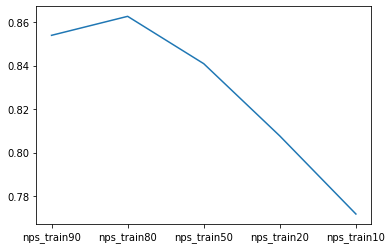

In [72]:
import matplotlib.pyplot as plt

plt.plot(trained_list, accuracy_list)

plt.show()


From the graph we can see that the optimal train/test ratio is 80/20.

## 3 – Tagging with probabilities

**Hidden Makrov Models (HMMs) can be used to solve Part-of-Speech (POS) tagging. Use HMMs to
calculate probabilities for words and tags, using the appended code.**

**(a) Implement the missing pieces of the function task3a() found in the appended code. Also found on
the next page for reference.**

In [73]:
import nltk
from nltk.corpus import brown
# see https://nltk.readthedocs.io/en/latest/api/nltk.html
# define distinguishable start/end tuples of tag/word
# used to mark sentences
START = ("START", "START")
END = ("END", "END")

def get_tags(corpus):
    tags_words = []
    for sent in corpus.tagged_sents():
        tags_words.append(START)
        # shorten tags to 2 characters each for simplicity
        tags_words.extend([(tag[:2], word) for (word, tag) in sent])
        tags_words.append(END)

    return tags_words

def probDist(corpus, probability_distribution, tag_observation_fn):
    tag_words = get_tags(corpus)
    tags = [tag for (tag, _) in tag_words]
    # conditional frequency distribution over tag/word
    cfd_tagwords = nltk.ConditionalFreqDist(tag_words)
    cpd_tagwords = nltk.ConditionalProbDist(cfd_tagwords, probability_distribution)
    # conditional frequency distribution of observations:
    cfd_tags = nltk.ConditionalFreqDist(tag_observation_fn(tags))
    cpd_tags = nltk.ConditionalProbDist(cfd_tags, probability_distribution)
    
    return cpd_tagwords, cpd_tags

def task3a():
    corpus = brown
    # maximum likelihood estimate to create a probability distribution 
    probability_distribution = nltk.probability.MLEProbDist
    tag_observation_fn = nltk.bigrams
    return probDist(corpus, probability_distribution, tag_observation_fn)


**(b) Print the probablity of:
• a verb (VB) being “run”
• a preposition (PP) being followed by a verb
A template is found in the code under task3b()**

In [74]:
def prettify(prob):
    return "{}%".format(round(prob * 100, 4))
    
def task3b():
    tagwords, tags = task3a()
    prob_verb_is_run =  tagwords['VB'].prob('run')
    prob_v_follows_p = tags['PP'].prob('VB')
    print("Prob. of a Verb(VB) being 'run' is", prettify(prob_verb_is_run))
    print("Prob. of a Preposition(PP) being followed by a Verb(VB) is", prettify(prob_v_follows_p))
    
task3b()

Prob. of a Verb(VB) being 'run' is 0.1329%
Prob. of a Preposition(PP) being followed by a Verb(VB) is 25.1591%


**(c) Print the 10 most common words for each of the tags NN, VB, JJ**

In [75]:
cpd_tagwords, cpd_tags = task3a()

In [76]:
tags = ['NN','VB','JJ']

for tag in tags:
    print(tag, cpd_tagwords[tag].freqdist().most_common(10))

NN [('time', 1555), ('man', 1148), ('Af', 994), ('years', 942), ('way', 883), ('people', 809), ('men', 736), ('world', 684), ('life', 676), ('year', 647)]
VB [('said', 1943), ('made', 1119), ('make', 765), ('see', 727), ('get', 719), ('know', 676), ('came', 621), ('used', 610), ('go', 604), ('come', 589)]
JJ [('new', 1060), ('such', 903), ('own', 750), ('good', 693), ('great', 592), ('New', 575), ('old', 568), ('American', 535), ('small', 517), ('long', 515)]


**(d) Print the probability of the tag sequence PP VB VB DT NN for the sentence “I can code some
code”**

In [77]:
prob = cpd_tagwords["PP"].prob("I") * cpd_tags["PP"].prob("VB") * cpd_tagwords["VB"].prob("can") * cpd_tags["VB"].prob("VB")* cpd_tagwords["VB"].prob("code")  * cpd_tags["VB"].prob("DT") * cpd_tagwords["DT"].prob("some") * cpd_tags["DT"].prob("NN") * cpd_tagwords["NN"].prob("code") * cpd_tags["VB"].prob("NN")

print(prob)


3.646546474434433e-22
